# Stacked barchart for timeline of genome sequences at NCBI

In [1]:
import pandas as pd
from pathlib import Path
import random
import yaml
import datetime
import plotly.express as px
import plotly.graph_objs as go
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
warnings.filterwarnings('ignore')

In [2]:
with open("config.yaml", "r") as f:
    notebook_configuration = yaml.safe_load(f)
notebook_configuration

{'bgcflow_dir': '/datadrive/bgcflow'}

In [12]:
# Write samples.csv table to config directory of qc_strepto_ncbi project
bgcflow_dir = Path(notebook_configuration["bgcflow_dir"])
project_name_1 = "qc_strepto_ncbi"
processed_dir_1 = bgcflow_dir / "data" / "processed" / project_name_1

project_name_2 = "qc_gtdbtk"
processed_dir_2 = bgcflow_dir / "data" / "processed" / project_name_2

# Read output tables from the processed directory
ncbi_meta_table = processed_dir_1 / "tables"/ "df_ncbi_meta.csv"
df_ncbi_meta = pd.read_csv(ncbi_meta_table, index_col= 0)

filters_table = processed_dir_1 / "tables"/ "df_filters.csv"
df_filters = pd.read_csv(filters_table, index_col= 0)

In [13]:
df = df_filters[df_filters.genus == "Streptomyces"]

for genome_id in df.index:
    # Define quality levels
    if genome_id in df_ncbi_meta.index:
        date_str = df_ncbi_meta.loc[genome_id, 'date']
        date_obj = datetime.datetime.strptime(date_str, "%Y-%m-%d")
        df.loc[genome_id, 'year'] = str(date_obj.year)
        df.loc[genome_id, 'date'] = date_str
    else:
        df.loc[genome_id, 'year'] = "2023"
        df.loc[genome_id, 'date'] = ""
        df.loc[genome_id, 'quality'] = "HQ_NEW"

In [14]:
df_stats = df.copy()
df = df.groupby(['year', 'quality']).size().reset_index(name='counts')

# Manually add values for missing data points to be 0
max_idx = df.shape[0]
df.loc[max_idx, "year"] = "2008"
df.loc[max_idx, "quality"] = "MQ"
df.loc[max_idx, "counts"] = 0

df.loc[max_idx + 1, "year"] = "2009"
df.loc[max_idx + 1, "quality"] = "LQ"
df.loc[max_idx+ 1, "counts"] = 0

# df.loc[max_idx + 2, "year"] = "NBC"
# df.loc[max_idx + 2, "quality"] = "MQ"
# df.loc[max_idx+ 2, "counts"] = 0

# df.loc[max_idx + 3, "year"] = "NBC"
# df.loc[max_idx + 3, "quality"] = "LQ"
# df.loc[max_idx+ 3, "counts"] = 0

df.sort_values('year', inplace=True)
df['cumulative_counts'] = df.groupby('quality')['counts'].cumsum()

In [15]:
# # Define colors for each quality
# colors = {
#     'LQ': '#E69F00',  # Orange
#     'MQ': '#56B4E9',  # Sky Blue
#     'HQ': '#009E73',  # Bluish Green
#     'HQ_NBC': '#F0E442',  # Yellow
# }

# # Define order of qualities
# qualities = ["LQ", "MQ", "HQ", "HQ_NBC"]

# # Calculate total values for each year
# total_values = df.groupby('year')['cumulative_counts'].sum()

# # Create a Figure object
# fig = go.Figure()

# # Add bars for each quality in the defined order
# for quality in qualities:
#     df_filtered = df[df['quality'] == quality]
#     fig.add_trace(
#         go.Bar(
#             x=df_filtered['year'], 
#             y=df_filtered['cumulative_counts'], 
#             name=quality,
#             marker_color=colors[quality]
#         )
#     )

# # Add scatter plot for total values
# fig.add_trace(
#     go.Scatter(
#         x=total_values.index,
#         y=total_values.values + 70,  # Add an offset to position the text above the bars
#         mode='text',  # Set mode to text to display only text (no markers or lines)
#         text=total_values.values,  # Set text to total values
#         textposition='middle center',  # Position text in the middle center of the coordinates
#         showlegend=False  # Don't show this trace in the legend
#     )
# )

# # Update layout
# fig.update_layout(
#     title={
#         'text': "Streptomyces genome sequences over the years",
#         'y':0.85,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top'
#     },
#     xaxis_title="Year",
#     xaxis_tickangle=-90,  # Rotate x-axis ticks by 90 degrees
#     yaxis_title="Genomes",
#     barmode='stack',
#     autosize=False,
#     width=600,   # you can change width and height as per your needs
#     height=400,
# )

# # # Save as SVG
# # fig.write_image("assets/figures/Figure_1/c.svg")

# # # Save as PNG
# # fig.write_image("assets/figures/Figure_1/c.png")

# fig.show()

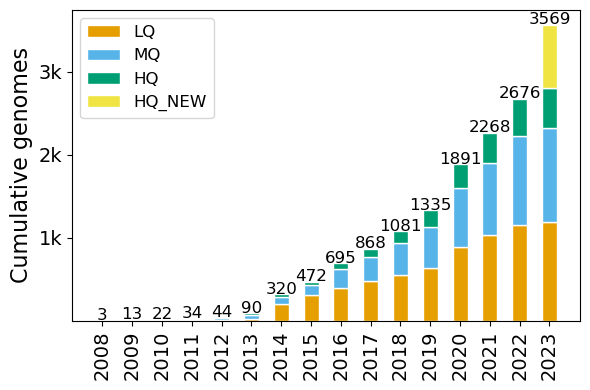

In [16]:
# Ensure the 'year' column is of integer type
df['year'] = df['year'].astype(int)

# Define colors for each quality, as per your given colors
colors = {
    'LQ': '#E69F00',
    'MQ': '#56B4E9',
    'HQ': '#009E73',
    'HQ_NEW': '#F0E442',
}

# Define order of qualities
qualities = ["LQ", "MQ", "HQ", "HQ_NEW"]

# Calculate total values for each year
total_values = df.groupby('year')['cumulative_counts'].sum()

# Plotting
fig, ax = plt.subplots(figsize=(6, 4))

# Initialize bottom to 0 for stacking, with an index matching unique years
bottom = pd.Series([0] * len(df['year'].unique()), index=df['year'].unique().astype(int))

for quality in qualities:
    df_filtered = df[df['quality'] == quality]
    cumulative_counts = df_filtered.groupby('year')['cumulative_counts'].sum()
    ax.bar(cumulative_counts.index, cumulative_counts, 
           bottom=bottom.loc[cumulative_counts.index].values, 
           color=colors[quality], edgecolor='white', label=quality, width=0.5)
    bottom.loc[cumulative_counts.index] += cumulative_counts

# Adding the text on top of the bars
for idx, value in total_values.items():
    ax.text(idx, value + 5, str(int(value)), ha='center', fontsize=12)  # Adjust fontsize as needed

# Function to format the tick labels
def thousands_formatter(x, pos):
    return f'{int(x/1000)}k'

# Set custom y-ticks
desired_ticks = np.array([1000, 2000, 3000])  # The desired ticks in data units
ax.set_yticks(desired_ticks)

# Use the formatter to format the tick labels
ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Set custom x-ticks to ensure all years are displayed
years = df['year'].unique()  # Assuming 'year' is your x-axis data
ax.set_xticks(years)  # This sets every unique year as an x-tick

# Rotate x-axis labels
ax.set_xticklabels(years, rotation=90, ha='center')  # Set x labels with rotation

# Customize font sizes
# ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Cumulative genomes', fontsize=16)
ax.legend(fontsize=12)

# Set custom font sizes for x-tick labels
ax.tick_params(axis='x', labelsize=14)  # Change the number for your desired font size

# Set custom font sizes for y-tick labels
ax.tick_params(axis='y', labelsize=14)  # Change the number for your desired font size

# Show the plot
plt.tight_layout()

# Save as SVG
plt.savefig('assets/figures/Figure_1/timeline.svg', format='svg', bbox_inches="tight")

# Save as PNG
plt.savefig('assets/figures/Figure_1/timeline.png', format='png', bbox_inches="tight")

plt.show()

,year,quality,counts,cumulative_counts
0,2008,HQ,1.0,1.0
1,2008,LQ,2.0,2.0
47,2008,MQ,0.0,0.0
48,2009,LQ,0.0,2.0
2,2009,HQ,1.0,2.0
3,2009,MQ,9.0,9.0
4,2010,HQ,5.0,7.0
5,2010,LQ,2.0,4.0
6,2010,MQ,2.0,11.0
7,2011,HQ,6.0,13.0
